In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
colab.fan/py2


**Import necessary libraries**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Input

**Create Data set needed to train and test the network**

In [ ]:
IMG_HEIGHT = 100
IMG_WIDTH = 100

In [ ]:
train_ds_normal = tf.data.Dataset.list_files('/content/drive/My Drive/AI for Health/Data set/chest_xray/train/NORMAL/*.jpeg')
train_ds_pneumonia = tf.data.Dataset.list_files('/content/drive/My Drive/AI for Health/Data set/chest_xray/train/PNEUMONIA/*.jpeg')

val_ds_normal = tf.data.Dataset.list_files('/content/drive/My Drive/AI for Health/Data set/chest_xray/val/Normal/*.jpeg')
val_ds_pneumonia = tf.data.Dataset.list_files('/content/drive/My Drive/AI for Health/Data set/chest_xray/val/PNEUMONIA/*.jpeg')

test_ds_normal = tf.data.Dataset.list_files('/content/drive/My Drive/AI for Health/Data set/chest_xray/test/NORMAL/*.jpeg')
test_ds_pneumonia = tf.data.Dataset.list_files('/content/drive/My Drive/AI for Health/Data set/chest_xray/test/PNEUMONIA/*.jpeg')

In [ ]:
for i in train_ds_normal.take(2):
    print(i.numpy())

b'/content/drive/My Drive/AI for Health/Data set/chest_xray/train/NORMAL/IM-0137-0001.jpeg'
b'/content/drive/My Drive/AI for Health/Data set/chest_xray/train/NORMAL/IM-0117-0001.jpeg'


In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  if parts[-2] == 'NORMAL':
     lab = 1
  else:
     lab = 0   
  return lab

In [ ]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels= 1)
    img = tf.image.convert_image_dtype(img, dtype= tf.float32)
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [ ]:
def process_path(files_path):
    label = get_label(files_path)  
    img = tf.io.read_file(files_path)
    img = decode_img(img)
    return img, label

In [ ]:
ds_train_nor = train_ds_normal.map(process_path, num_parallel_calls=5)
ds_train_pne = train_ds_pneumonia.map(process_path, num_parallel_calls=5)
ds_train = ds_train_nor.concatenate(ds_train_pne)

ds_val_nor = val_ds_normal.map(process_path, num_parallel_calls=5)
ds_val_pne = val_ds_pneumonia.map(process_path, num_parallel_calls=5)
ds_val = ds_val_nor.concatenate(ds_val_pne)

ds_test_nor = test_ds_normal.map(process_path, num_parallel_calls=5)
ds_test_pne = test_ds_pneumonia.map(process_path, num_parallel_calls=5)
ds_test = ds_test_nor.concatenate(ds_test_pne)


In [ ]:
for img, lab in ds_test.take(2):
    print(img.shape)
    print(lab.shape)

(100, 100, 1)
()
(100, 100, 1)
()


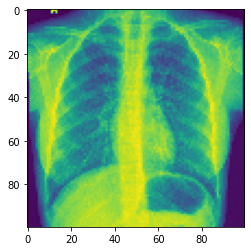

In [ ]:
plt.imshow(img.numpy()[:,:,0])

In [ ]:
def configure_dataset(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size= 1000)
    ds = ds.batch(16)
    ds = ds.prefetch(buffer_size= 1000)
    return ds

In [ ]:
ds_train = configure_dataset(ds_train)
ds_val = configure_dataset(ds_val)
ds_test = configure_dataset(ds_test)

**Now it's time to get data from final prepared datasets**

In [ ]:
image_batch, label_batch = next(iter(ds_train))

This picture label is 0


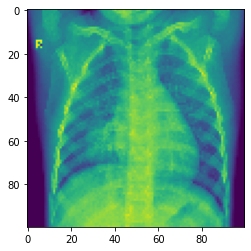

In [ ]:
plt.imshow(image_batch[1,:,:,0].numpy())
print('This picture label is {}'.format(label_batch[1].numpy()))

**Define the network structure**

In [ ]:
class Chest_class(Model):
      
      def __init__(self, num_filter = 528, kernel_size= 5):
          super(Chest_class, self).__init__()

          self.num_filter = num_filter
          self.kernel_size = kernel_size
          
          self.conv_1_layer_1 = Conv2D(int(num_filter/4), kernel_size)
          self.max_layer_1 = MaxPooling2D()
          self.conv_2_layer_1 = Conv2D(int(num_filter/4), kernel_size)
          self.batch_layer_1 = BatchNormalization()

          self.conv_1_layer_2 = Conv2D(int(num_filter/3), kernel_size)
          self.max_layer_2 = MaxPooling2D()    
          self.conv_2_layer_2 = Conv2D(int(num_filter/3), kernel_size)
          self.batch_layer_2 = BatchNormalization()
 
          self.flatt = Flatten()
          self.dense = Dense(1, 'sigmoid')

      def call(self, input):

          'first layer'
          x = self.conv_1_layer_1(input)
          x = self.max_layer_1(x)
          x = self.conv_2_layer_1(x)
          x = self.batch_layer_1(x)
         
          'second layer'
          x = self.conv_1_layer_2(x)
          x = self.max_layer_2(x)
          x = self.conv_2_layer_2(x)
          x = self.batch_layer_2(x) 

          x = self.flatt(x)
          x = self.dense(x)
          
          return x


In [ ]:
inp = Input(shape= (100, 100, 1))
model_obj = Chest_class()
out = model_obj(inp)

In [ ]:
model = Model(inputs = inp, outputs = out)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
chest_class (Chest_class)    (None, 1)                 1841005   
Total params: 1,841,005
Trainable params: 1,840,389
Non-trainable params: 616
_________________________________________________________________


**Define loss and optimizer then start training**

In [ ]:
opt = SGD(0.01)
loss = BinaryCrossentropy(name= 'binary_cross_entropy')
metric = Accuracy(name= 'accuracy')

In [ ]:
@tf.function
def train_step(imgs, labs):
    with tf.GradientTape() as tape :
         pred = model(imgs)
         ls = loss(labs, pred)
    ac = metric(labs, tf.round(pred))
    trainable_vars = model.trainable_variables
    grads = tape.gradient(ls, trainable_vars)
    opt.apply_gradients(zip(grads, trainable_vars))
    return ls, ac, grads    

In [ ]:
@tf.function
def test_step(imgs, labs):
    pred = model(imgs)
    ls = loss(labs, tf.round(pred))
    ac = metric(labs, pred)
    return ls, ac

In [ ]:
num_epochs = 20


for i in range(num_epochs):

    list_loss_train = []
    list_loss_val = []

    list_acc_train = []
    list_acc_val = []


    for img, lab in ds_train:
        loss_batch, acc_batch, grad_batch = train_step(img, lab)
        list_loss_train.append(loss_batch.numpy())
        list_acc_train.append(acc_batch.numpy())

    for img, lab in ds_val:
        loss_batch, acc_batch = test_step(img, lab)
        list_loss_val.append(loss_batch.numpy())
        list_acc_val.append(acc_batch.numpy())


    print('epoch {}: loss_train {:3.2f}, acc_train {:3.2f}, loss_val {:3.2f}, acc_val {:3.2f}'.format(i+1, 
    np.mean(list_loss_train), np.mean(list_acc_train), np.mean(list_loss_val), np.mean(list_acc_val)))
      

epoch 1: loss_train 0.09, acc_train 0.26, loss_val 8.58, acc_val 0.25
epoch 2: loss_train 0.19, acc_train 0.26, loss_val 8.58, acc_val 0.26
epoch 3: loss_train 0.11, acc_train 0.27, loss_val 6.20, acc_val 0.27
epoch 4: loss_train 0.08, acc_train 0.27, loss_val 8.10, acc_val 0.27
epoch 5: loss_train 0.12, acc_train 0.28, loss_val 8.58, acc_val 0.28
epoch 6: loss_train 0.13, acc_train 0.28, loss_val 7.15, acc_val 0.28
epoch 7: loss_train 0.16, acc_train 0.29, loss_val 10.48, acc_val 0.28
epoch 8: loss_train 0.36, acc_train 0.29, loss_val 8.10, acc_val 0.29
epoch 9: loss_train 0.08, acc_train 0.29, loss_val 5.72, acc_val 0.29
epoch 10: loss_train 0.07, acc_train 0.30, loss_val 6.20, acc_val 0.30
epoch 11: loss_train 0.10, acc_train 0.30, loss_val 9.05, acc_val 0.30
epoch 12: loss_train 0.10, acc_train 0.30, loss_val 4.29, acc_val 0.30
epoch 13: loss_train 0.06, acc_train 0.31, loss_val 8.10, acc_val 0.31
epoch 14: loss_train 0.07, acc_train 0.31, loss_val 6.20, acc_val 0.31
epoch 15: loss

**Get the performance of the network on the "test set"**

In [ ]:
list_loss_test = []
list_acc_test = []

for img, lab in ds_test:
    loss_batch, acc_batch = test_step(img, lab)          
    list_loss_test.append(loss_batch.numpy())
    list_acc_test.append(acc_batch.numpy())


print('test_loss {:3.2f}, test_accuracy {:3.2f}'.format(np.mean(list_loss_test), np.mean(list_acc_test)))    

test_loss 9.26, test_accuracy 0.32
